TLDR : use DECAPS IMDB catalog containing headers from all DECAPS single-epoch images / catalogs, and MAF simulated sky, to obtain images at different densities. 

In [11]:
# Imports 
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Column
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.table import hstack
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import numpy as np
from astropy.io import fits

**Table of contents:** <a id='toc'></a>
   * [reading of Galfast data into AstroPy table](#readGalfast)
   * [plotting density percentiles : Fig. 2](#plotPercentiles)
   * [counting Galfast sky](#countGalfast)
   * [plotting the Galfast density map, contours: Fig. 1,4 ](#plotGalfast)
   * [plotting the DECAPS on top of Galfast density map: Fig. 5](#plotDecaps)

### Automated reading of Galfast data <a id='readGalfast'></a>

[Go to top](#toc)

In [4]:
def make_healpix_table(r_max=24.5):
    ''' A convenience function 
    to read in the MAF simulation data,
    and given the limiting r magnitude, 
    return stellar density per healpixel,
    and the fraction of healpixels with higher
    density , together with ra,dec coord 
    of each healpixel. We use the constraint 
    r < r_max, with  65 magnitude bins between 
    15 and 28 mag every 0.2 mag. 
    
    '''
    # the data consists of 
    # data['starDensity'],  expressed as stars / sq. deg  ,  per pixel, per magnitude
    # data['bins'], defining the magnitude ranges for each of the 65 magnitude bins 
    # data['overMaxMask'], which tells where there are more than 1e6 stars 
    data = np.load('starDensity_r_nside_64.npz')


    # Cumulative number counts, units of stars/sq deg. Array at healpix locations
    # magnitude bins 
    mag_bins = data['bins'].copy()
    # pixels where there were so many  (1e6 ) stars some were skipped
    mask = data['overMaxMask'].copy()
    # in this simulation none were skipped : 
    # np.sum(mask) = 0

    # select only bins up to r_max - then selecting the final bin will 
    # give us the source count up to depth of r_max mag 
    bright_mag_idx, = np.where(mag_bins<r_max)
    print('Selecting only the source density up \
    to the depth of ', r_max, ' mag')
    faintest_mag_idx = bright_mag_idx[-1]

    # Since the data is already cumulative, just choose the  last bin: 
    # this will have the number of stars up to the faintest magnitude 
    # bin in a given  healpixel 
    starDensity_lt_245 = data['starDensity'][:,faintest_mag_idx]
    # len(starDensity_lt_245) = len(data['starDensity]) = 49142

    # Generate the ra, dec array from healpy
    nside = hp.npix2nside(np.size(mask))
    lat,ra = hp.pix2ang(nside, np.arange(np.size(mask)))
    dec = np.pi/2-lat

    # only select those healpixels for which we have any simulation data ...
    m = starDensity_lt_245 > 0

    density = starDensity_lt_245[m]
    ra = ra[m]
    dec = dec[m]

    # For each pixel calculate how many pixels have a higher or equal density 
    N_px_greater  = np.zeros_like(density)
    for i in range(len(density)):
        N_px_greater[i]=np.sum(density>=density[i])

    # calculate the fraction of pixels that have a higher density (by area)
    frac_greater  = N_px_greater /  len(density)

    # Make an AstroPy table with healpix data...

    healpix_table = Table([density, ra,dec, N_px_greater, frac_greater], 
                          names=('source_density','ra_rad','dec_rad', 'N_px_greater', 
                                 'frac_greater'))
    return healpix_table , nside



### Figure: Galfast density definitions <a id='plotPercentiles'></a>

[Go to top](#toc)

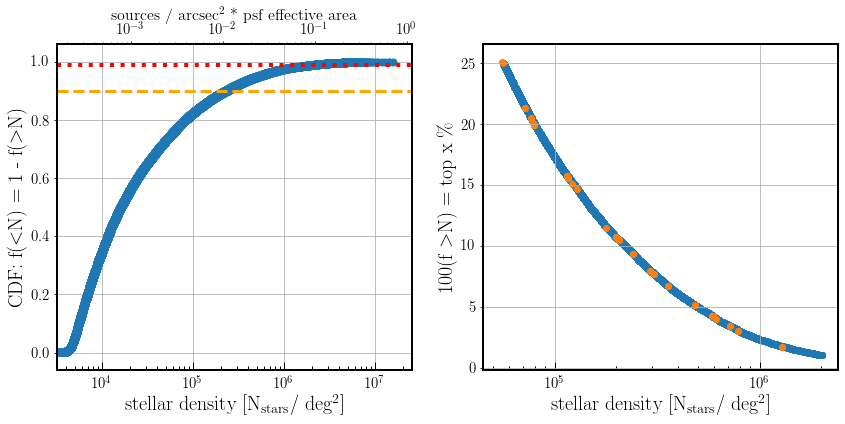

In [99]:
# Use the data for the entire simulation ...  
# Instead of making two plots, make one plot , with two x-axes...
%matplotlib inline
# Generic plot settings...
import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20


# initialize plotting space 
fig,axs = plt.subplots(1,2,figsize=(14,6))
ax1,ax3 = axs[0],axs[1]


# LEFT PANEL 
#x = np.log10(healpix_table['source_density'])
x = healpix_table['source_density']
y = 1-healpix_table['frac_greater']
ax1.scatter(x,y, lw=2, label=' ')
ax1.semilogx()
#ax1.xaxis.set_tick_params(width=5)

ax1.set_xlabel('stellar density [N'+r'$_{\mathrm{stars}}$'+'/ deg'+r'$^{2}$'+']')#, 
               #  fontsize=16)
ax1.set_ylabel(r'CDF: f(\textless N) = 1 - f(\textgreater N) ')
ax1.set_xlim(np.power(10,3.5),)

psf_eff_area = 0.64
dimensionless_density = ( x /  (3600*3600) ) * psf_eff_area
#x1 = np.log10(dimensionless_density)
x1 = dimensionless_density
ax2 = ax1.twiny()

ax2.scatter(x1,y, lw=2, label=' ')
ax2.semilogx()

#ax2.set_xlim(np.log10(np.power(10,3.5)/ (3600*3600)  * psf_eff_area), )
ax2.set_xlim((np.power(10,3.5)/ (3600*3600)) * psf_eff_area)
ax2.set_xlabel('sources / arcsec'+r'$^{2}$'+' * psf effective area', 
                 fontsize=16)
ax1.grid()
ax2.axhline(0.9, ls='--', lw=3, color='orange', label='top 10% ')
ax2.axhline(0.99, ls=':', lw=4, color='red',label='top 1% ')
#plt.legend(nrow=2)


# RIGHT PANEL 

# show the sampled population
perc = 100*(healpix_table['frac_greater'])
m = (1<perc)*(perc < 25)

true_x = healpix_table['source_density'][m]
true_y = perc[m]
ax3.scatter(true_x, true_y)
ax3.semilogx()
visit_table = Table.read('decaps_lsst_visit_info.txt', format='ascii')

x = visit_table['MAFnumber_lsst']
y = visit_table['density_lsst']
ax3.scatter(x,y)
ax3.set_ylabel(r'100(f \textgreater N) = top x \%')
ax3.set_xlabel('stellar density [N'+
               r'$_{\mathrm{stars}}$'+'/ deg'+r'$^{2}$'+']')
ax3.grid()

for ax in [ax1,ax3]:
    # list of all params 
    # https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.tick_params.html
    ax.tick_params('x', length=8, width=1, which='major', direction='in',pad=8)
    ax.tick_params('x', length=4, width=1, which='minor', direction='in')
    
plt.savefig('MAF_density_definitions.png', bbox_inches='tight')

### Counting the Galfast stars... <a id='countGalfast'></a>

[Go to top](#toc)

"What I would like to know too is the number of all stars across the sky (the 
sum of all healpix values; it should be a few billion), and then the number
(the sum) in 
- top 1%, of all healpix, 
- top 10% of all healpix, 
- sum for healpix from the Galactic confusion zone: |b| within the straight
  lines starting at |b| = 10 deg at l=0 deg, and dropping linearly to 0 at 
  l = 90 and l = 270.  "


In [129]:
# Area of a pixel = Total area of the sky / total number of healpixels ... 

# In steradians the area is equivalent to 
# number_of_pixels = np.size(mask)
# px_area_sq_rad = 4*np.pi / number_of_pixels

# Obtain the pixel area 
px_area_sq_deg = hp.nside2pixarea(nside,degrees=True) # in square degrees 
px_area_sq_rad =  hp.nside2pixarea(nside, degrees=False)



In [133]:
# So there are 49142 healpixels,  but only 38784
# have nonzero entries ...This is the length of 
# healpix_table 

# In healpy by definition all pixels have equal area :
# Hierarchical Equal Area isoLatitude Pixelization 
# https://workshops.ift.uam-csic.es/files/208/Healpix.pdf
N_all_stars = np.sum(healpix_table['source_density'] * px_area_sq_deg)
print(N_all_stars)
# note : these are only stars brighter than 24.5 mag ! 



3743045410.5


In [134]:
for density_percentile in [1,10]:
    print(density_percentile)
    density = density_percentile / 100.0
    select_density  = healpix_table['frac_greater'] < density
    N_stars = np.sum(healpix_table[select_density]['source_density'] * px_area_sq_deg)
    print(N_stars)

1
1093643236.12
10
2829730651.68


In [ ]:
# Galactic confusion zone : 
# |b| within the straight
#  lines starting at |b| = 10 deg at l=0 deg, and dropping linearly to 0 at 
# l = 90 and l = 270.  "

In [215]:
# I can code that up using SkyCoord : 
healpix_coords = SkyCoord(healpix_table['ra_rad'],
                          healpix_table['dec_rad'], frame='icrs', unit='rad')



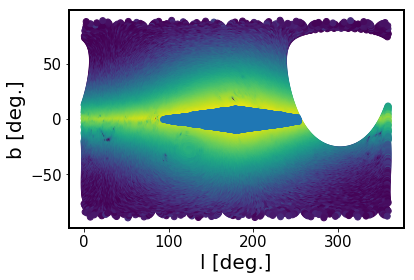

In [221]:
l,b = healpix_coords.galactic.l.deg, healpix_coords.galactic.b.deg
x = np.remainder(l+360,360) # shift RA values
#ind = x>180
#x[ind] -=360  
mRight  = l < 180
mLeft  = l > 180
l[mLeft] = l[mLeft] - 180
l[mRight] = l[mRight] + 180


plt.scatter(l,b,c=1-healpix_table['frac_greater'])
a = 0.1111111111111111
m1 = b < -(a * l)  + 30  # l1
m2 = b >  (a * l)  - 30  # l2
m3 = b > -(a * l)  + 10  # l3 
m4 = b <  (a * l)  - 10  # l4
m = m1*m2*m3*m4  # select exclusion zone
plt.scatter(l[m], b[m])
plt.xlabel('l [deg.]')
plt.ylabel('b [deg.]')
plt.savefig('galactic_l_b_healpixels_orig.png', bbox_inches='tight')

In [222]:
N_sources =  np.sum(healpix_table[m]['source_density'] * px_area_sq_deg)
print(N_sources)

2189933601.04


In [156]:
# Calculating equations of straight lines
# that define the confusion zone

# in l, b : galactic coordinates ... ` 
vertices = [[270,0], [180,-10], [90,0], [180,10]]

# line1 
x1,y1 = [180,10] # D
x2,y2 = [270,0] # A
a = (y2-y1) / (x2-x1)
b = y1 - a * x1
print('line: y = ',a,'*x',b)

# line2
x1,y1 = [270,0] # A 
x2,y2 = [180,-10] # B
a = (y2-y1) / (x2-x1)
b = y1 - a * x1
print('line: y = ',a,'*x',b)

# line3
x1,y1 = [180,-10] # B , 
x2,y2 = [90,0] # C 
a = (y2-y1) / (x2-x1)
b = y1 - a * x1
print('line: y = ',a,'*x',b)

# line4
x1,y1 = [90,0] # C
x2,y2 = [180,10] # D 
a = (y2-y1) / (x2-x1)
b = y1 - a * x1
print('line: y = ',a,'*x',b)

line: y =  -0.1111111111111111 *x 30.0
line: y =  0.1111111111111111 *x -30.0
line: y =  -0.1111111111111111 *x 10.0
line: y =  0.1111111111111111 *x -10.0


1.0

"So, the question is what is the total area and total stellar count of all healpix 
that satisfy 
1) main survey area, defined by: Dec > -65 deg and Dec < +5 
     (for sanity test: w/o other constraints, this should be 20,491 sq.deg.)
2) AND stellar density lower than rho, with (per sq. deg.) 
rho = 35,000; 100,000; 200,000, 400,000, 800,000, 1 million, 2 million " 

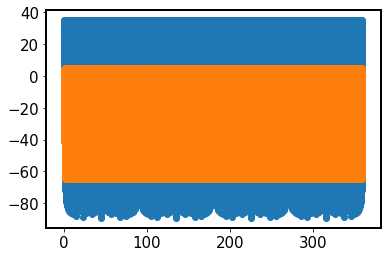

In [167]:
ra,dec =healpix_coords.ra.deg, healpix_coords.dec.deg
plt.scatter(ra,dec)
m = (dec>-65) * (dec<5)
plt.scatter(ra[m], dec[m])

In [176]:
dec = healpix_coords.dec.deg
m = (dec>-65) * (dec<5)
ttl_area_main_survey = len(healpix_table[m]) * px_area_sq_deg
print('Main survey area:')
print('Total area:', ttl_area_main_survey, ' sq.deg.')
N_main_survey = np.sum(healpix_table[m]['source_density'] * px_area_sq_deg)
print('Total count:', N_main_survey)

Main survey area:
Total area: 20569.4086568  sq.deg.
Total count: 3149070026.14


In [223]:
l,b = healpix_coords.galactic.l.deg, healpix_coords.galactic.b.deg

# Shift l to include exclusion zone constraint
mRight  = l < 180
mLeft  = l > 180
l[mLeft] = l[mLeft] - 180
l[mRight] = l[mRight] + 180

# Check  the same adding a constraint on
# stellar density per sq.deg. : 
for rho in [35000, 1e5, 2e5, 4e5, 8e5, 1e6, 2e6]:
    #print('stellar density < ', rho, 'per sq.deg.')
    
    # constrain area 
    m1 = (dec>-65) * (dec<5)
    
    # constrain density
    m2 = healpix_table['source_density'] < rho
    
    # remove exclusion zone 
    a = 0.1111111111111111
    ml1 = b < -(a * l)  + 30  # l1
    ml2 = b >  (a * l)  - 30  # l2
    ml3 = b > -(a * l)  + 10  # l3 
    ml4 = b <  (a * l)  - 10  # l4
    m = ml1*ml2*ml3*ml4  # selects inside exclusion
    m3 = ~m
    
    # combine 
    m = m1 * m2 * m3
    
    # calculate area 
    area = len(healpix_table[m]) * px_area_sq_deg
    
    # calculate N sources 
    N_sources = np.sum(healpix_table[m]['source_density'] * px_area_sq_deg)
    
    #print('Area:',area , ', N sources:',N_sources, 'per sq.deg.')
    print('%8i, %6i, %11i'%(rho,  area, N_sources))

   35000,  13013,   161257462
  100000,  16246,   354919962
  200000,  17636,   551053198
  400000,  18590,   819316472
  800000,  19055,  1071501394
 1000000,  19084,  1096534196
 2000000,  19084,  1096534196


Wrap the steps above to provide, given r_max as a variable: 
    
* total number of stars in all healpixels
* N stars in top 1%, top 10%
* N stars in exclusion zone
* N stars in the main survey area with / without exclusion zone
* N stars and area of all healpixels that are  in the main survey area, without exclusion zone, and stellar density lower than rho, with (per sq. deg.) 
rho = 35,000; 100,000; 200,000, 400,000, 800,000, 1 million, 2 million . 


In [4]:
def return_stellar_counts(healpix_table, nside):
    ''' A convenience function to take the table of 
    stellar density per healpixel, with 
    ra,dec in rad, and frac_greater,  
    and return :
    
    * N stars in all healpixels
    * N stars in healpixels within top 1%, top 10% density
    * N stars in exclusion zone
    * N stars in the main survey area with / without exclusion zone
    * N stars and area of all healpixels that are  in the main survey area, 
    without exclusion zone, and stellar density lower than rho, with (per sq. deg.) 
    rho = 35,000; 100,000; 200,000, 400,000, 800,000, 1 million, 2 million . 

    NOTE:  
    By default,  the healpixels have the galaxy centered on (l,b) = (0,0). 
    To make it easier to incorporate the confusion zone defined for 
    galaxy centered on (l,b) = (180,0), we shift the coordinates. 

    # Galactic confusion zone : 
    # |b| within the straight
    # lines starting at |b| = 10 deg at l=0 deg, 
    # and dropping linearly to 0 at 
    # l = 90 and l = 270.  
    
    '''
    px_area_sq_deg = hp.nside2pixarea(nside,degrees=True) 
    
    # * N stars in all healpixels
    N_all_stars = np.sum(healpix_table['source_density'] * px_area_sq_deg)
    print('N stars in all healpixels: ', N_all_stars)
    
    #* N stars in healpixels within top 1%, top 10% density
    for density_percentile in [1,10]:
        density = density_percentile / 100.0
        select_density  = healpix_table['frac_greater'] < density
        N_stars = np.sum(healpix_table[select_density]['source_density'] * px_area_sq_deg)
        print('N stars in top ', density_percentile,'%',' :', N_stars)
        
    #* N stars in confusion zone
    healpix_coords = SkyCoord(healpix_table['ra_rad'],
                          healpix_table['dec_rad'], frame='icrs', unit='rad')

    l,b = healpix_coords.galactic.l.deg, healpix_coords.galactic.b.deg
    # shift to coords where the galactic center is at (l,b)=(180,0)
    # rather than the traditional (l,b) = (0,0)
    mRight  = l < 180
    mLeft  = l > 180
    l[mLeft] = l[mLeft] - 180
    l[mRight] = l[mRight] + 180

    a = 0.1111111111111111
    m1 = b < -(a * l)  + 30  # l1
    m2 = b >  (a * l)  - 30  # l2
    m3 = b > -(a * l)  + 10  # l3 
    m4 = b <  (a * l)  - 10  # l4

    m_c = m1*m2*m3*m4 # inside confusion zone 
    N_sources =  np.sum(healpix_table[m_c]['source_density'] * px_area_sq_deg)
    print('N stars in confusion zone:', N_sources)
    
    # the main survey area
    dec = healpix_coords.dec.deg
    m_s = (dec>-65) * (dec<5)

    #* N stars in the main survey area with / without exclusion zone
    for m, label in zip([m_s, m_s*(~m_c)], ['with', 'without']):
        area = np.sum(m)* px_area_sq_deg
        N  =  np.sum(healpix_table[m]['source_density'] * px_area_sq_deg)
        print('N stars in the main survey area ',label,' conf.zone: ', N, ', ', 
              area,' sq.deg.')
        
        
    # * N stars and area of all healpixels that are  in the main survey area, 
    #  without exclusion zone, and stellar density lower than rho, with (per sq. deg.) 
    #  rho = 35,000; 100,000; 200,000, 400,000, 800,000, 1 million, 2 million . 
    print('N stars and area of healpixels in the main survey area')
    print(' without exclusion zone, stellar density lower than rho')
    print('rho   |   area   |   N stars ')
    for rho in [35000, 1e5, 2e5, 3e5,4e5, 6e5,7e5, 8e5, 1e6, 2e6]:
        # constrain area 
        m1 = m_s
        
        # constrain density
        m2 = healpix_table['source_density'] < rho

        # remove exclusion zone 
        m3 = ~m_c

        # combine 
        m = m1 * m2 * m3

        # calculate area 
        area = len(healpix_table[m]) * px_area_sq_deg

        # calculate N sources 
        N_sources = np.sum(healpix_table[m]['source_density'] * px_area_sq_deg)

        #print('Area:',area , ', N sources:',N_sources, 'per sq.deg.')
        print('%8i, %6i, %11i'%(rho,  area, N_sources))
    return
    

In [5]:
healpix_table, nside = make_healpix_table(24.5)
return_stellar_counts(healpix_table, nside)

Selecting only the source density up     to the depth of  24.5  mag
N stars in all healpixels:  3760504658.76
N stars in top  1 %  : 1096010819.71
N stars in top  10 %  : 2841708463.08
N stars in confusion zone: 2196948669.12
N stars in the main survey area  with  conf.zone:  3162936338.89 ,  20569.4086568  sq.deg.
N stars in the main survey area  without  conf.zone:  1103911114.29 ,  19084.6981985  sq.deg.
N stars and area of healpixels in the main survey area
 without exclusion zone, stellar density lower than rho
rho   |   area   |   N stars 
   35000,  13002,   161485401
  100000,  16226,   354829923
  200000,  17631,   553306692
  300000,  18235,   701100602
  400000,  18581,   821170347
  600000,  18920,   985810603
  700000,  19003,  1039541387
  800000,  19053,  1077311263
 1000000,  19084,  1103911114
 2000000,  19084,  1103911114


In [6]:
healpix_table, nside = make_healpix_table(27.5)
return_stellar_counts(healpix_table, nside)

Selecting only the source density up     to the depth of  27.5  mag
N stars in all healpixels:  8504072812.65
N stars in top  1 %  : 2650973634.22
N stars in top  10 %  : 6759484890.06
N stars in confusion zone: 5430192018.94
N stars in the main survey area  with  conf.zone:  7278834634.38 ,  20569.4086568  sq.deg.
N stars in the main survey area  without  conf.zone:  2192737211.11 ,  19084.6981985  sq.deg.
N stars and area of healpixels in the main survey area
 without exclusion zone, stellar density lower than rho
rho   |   area   |   N stars 
   35000,  10686,   179898977
  100000,  14492,   405990021
  200000,  16300,   663514129
  300000,  17112,   862753997
  400000,  17616,  1036741614
  600000,  18195,  1321063932
  700000,  18378,  1439524570
  800000,  18519,  1545442354
 1000000,  18742,  1743324923
 2000000,  19084,  2192737211


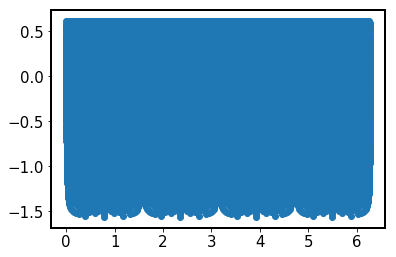

Selecting only the source density up     to the depth of  24.5  mag


### Plot Galfast densities <a id='plotGalfast'></a>

[Go to top](#toc)

In [ ]:
healpix_table, nside = make_healpix_table(24.5)
healpix_coords = SkyCoord(healpix_table['ra_rad'],
                          healpix_table['dec_rad'], 
                          frame='icrs', unit='rad')

# Define the tick formatter to have degrees ....
from matplotlib.ticker import FuncFormatter
import matplotlib
rcParams = matplotlib.rcParams
#from astroML.plotting import setup_text_plots
#setup_text_plots( usetex=True)

def degrees( x, pos=None):
    """
    Used to format the theta tick labels.  Converts the native
    unit of radians into degrees and adds a degree symbol.
    """
    degrees = (x / np.pi) * 180.0
    degrees = np.round(degrees)
    if rcParams['text.usetex'] and not rcParams['text.latex.unicode']:
        return r"$%0.0f^\circ$" % degrees
    else:
        return "%0.0f\u00b0" % degrees
    
    

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


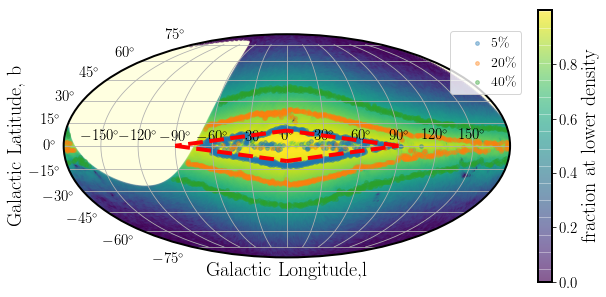

In [36]:
# express the MAF healpixel coords in galactic 
# coords,  in degrees 
longitude = healpix_coords.galactic.l.deg
latitude  = healpix_coords.galactic.b.deg

# convert degrees to radians
ind = longitude > 180
longitude[ind] -=360    # scale conversion to [-180, 180]
longitude = - longitude    # reverse the scale: East to the left
org = 0
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+org,360)

# color by the fraction of pixels at greater density (or 1 - that)
z = healpix_table['frac_greater']

# Plot in Mollweide projection the MAF densities 
# in Galactic coordinates 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide', facecolor ='LightYellow',
                    )

# plot the background too
imge = ax.scatter(np.radians(longitude),np.radians(latitude),  alpha=0.4,
                  s=14, c=1-z,
                  zorder=-5)  

# Loop over the brackets : 
for density in [ 0.05,0.20,0.4]:
    m = ((density-0.01) < z )* (z<(density+0.01))
    # convert degrees to radians
    ax.scatter(np.radians(longitude[m]),np.radians(latitude[m]), 
                      alpha=0.4,s=14,
                      zorder=-5, label=str(int(100*density))+'\%')  
    
# add a legend for densities 
plt.legend(fontsize=14, bbox_to_anchor=(0.85,0.7),
             fancybox=True,handletextpad=-0.5)


# plot the confusion zone 
xs = [0,-90,0,90,0]
ys = [10,0,-10,0,10]
for i in range(len(xs)-1):
    x0,y0 = xs[i],ys[i]
    x1,y1  = xs[i+1],ys[i+1]
    ax.plot(np.radians([x0,x1]), 
            np.radians([y0,y1]),
            lw=4,ls='--',c='red')
    
ax.set_xticklabels(tick_labels)  
ax.xaxis.set_major_formatter(FuncFormatter(degrees))
ax.set_xlabel('Galactic Longitude,l ')
ax.set_ylabel('Galactic Latitude, b')
ax.grid(True)
plt.colorbar(imge, label='fraction at lower density')
plt.savefig('MAF_densities.png', 
            bbox_inches='tight')

In [49]:
# http://www.astroml.org/book_figures/chapter1/fig_projections.html
#https://github.com/matplotlib/matplotlib/issues/1910/

# x and y values, which normally will be right ascensions and declinations, 
# or latitudes and longitudes, must be expressed in radians!.

# https://rabernat.github.io/research_computing/intro-to-basemap.html



array([-111.14610172, -112.40922547, -113.68110087, ...,   57.76112319,
         56.63352102,   56.3701897 ])

### Plot DECAPS fields on Galfast counts <a id='plotDecaps'></a>

[Go to top](#toc)

In [6]:
healpix_table, nside = make_healpix_table(24.5)
healpix_coords = SkyCoord(healpix_table['ra_rad'],
                          healpix_table['dec_rad'], 
                          frame='icrs', unit='rad')

Selecting only the source density up     to the depth of  24.5  mag


In [5]:
# express the decaps field coordinates as SkyCoord object ..
image_database = '../raw_data/decaps_catalogs/imdb.fits'
imdb_hdu = fits.open(image_database)
imdb = Table(imdb_hdu[1].data)
decaps_coords = SkyCoord(ra = imdb['ra'].data, dec = imdb['dec'].data, 
                       unit='degree', frame='icrs')



/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


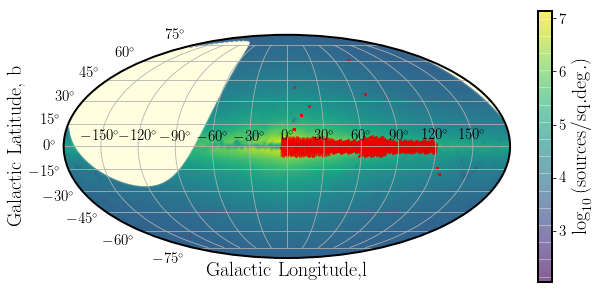

In [19]:
# plotting  in mollweide projection ...  
# express the MAF healpixel coords in galactic 
# coords,  in degrees 
longitude = healpix_coords.galactic.l.deg
latitude  = healpix_coords.galactic.b.deg

# convert degrees to radians
ind = longitude > 180
longitude[ind] -=360    # scale conversion to [-180, 180]
longitude = - longitude   # reverse the scale: East to the left

# color by the log of counts per sq deg 
z =  np.log10(healpix_table['source_density'].data)

# Plot in Mollweide projection the MAF densities 
# in Galactic coordinates 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide', facecolor ='LightYellow')

# convert degrees to radians
imge = ax.scatter(np.radians(longitude),np.radians(latitude),  alpha=0.4, s=14, c=z,
                  zorder=-5)  

# plot the DECAPS fields 
long, lat = decaps_coords.galactic.l.deg , decaps_coords.galactic.b.deg
ind = long > 180
long[ind] -=360    # scale conversion to [-180, 180]
long = - long   # reverse the scale: East to the left

ax.scatter(np.radians(long), np.radians(lat), alpha=0.07,c='red',s =4)

# plot the confusion zone 
# xs = [0,-90,0,90,0]
# ys = [10,0,-10,0,10]
# for i in range(len(xs)-1):
#     x0,y0 = xs[i],ys[i]
#     x1,y1  = xs[i+1],ys[i+1]
#     ax.plot(np.radians([x0,x1]), 
#             np.radians([y0,y1]),
#             lw=3,ls='--',c='red')
    
# set the tick labels with degree formatting 
origin = 0
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+origin,360)
ax.set_xticklabels(tick_labels)  
ax.xaxis.set_major_formatter(FuncFormatter(degrees))
ax.set_xlabel('Galactic Longitude,l ')
ax.set_ylabel('Galactic Latitude, b')
ax.grid(True)
cbar = plt.colorbar(imge)
cbar.set_label(r'$\log_{10}{(\mathrm{sources / sq.deg.})}$', labelpad=10)
plt.savefig('MAF_DECAPS.png',  bbox_inches='tight')





### Back to cross-matching MAF and DECAPS 

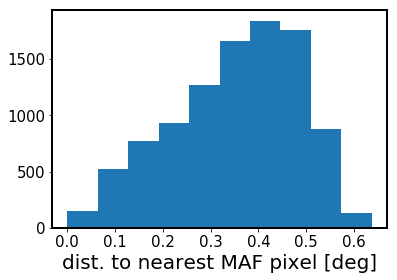

In [7]:
# Match positionally DECAPS to MAF table : 

# visit comes from dtacqnam 
x1 = len('/data_local/images/DTS/2016A-0327/DECam_00')
x2 = len('.fits.fz')
visit = [line[x1:-x2] for line in imdb['dtacqnam'].data.astype(str)]
imdb['visit'] = visit

# grab only relevant columns ...
decaps = imdb[[ 'visit','prodtype', 'exptime', 'mjd_obs', 
              'filterid', 'ra','dec', 'sb_name',  'magzero', 
               'catfname','dtnsanam'
              ]]

# Each DECAPS field is described by the center location ra,  
# as well as four corners. 
# The diagonal of such rectangle is 1.5918879 degrees, 
# so a good matching radius would be about 0.8 degrees 

# Find the MAF-derived densties for the DECAPS fields...
# coord1:  decaps_coords
# coord2 : healpix_coords

idx, d2d, d3d = decaps_coords.match_to_catalog_sky(healpix_coords)  

# stack the two catalogs 
decaps_maf = hstack([decaps, healpix_table[idx]])

# add column with distance to the nearest MAF pixel...
decaps_maf['d2d_deg'] = d2d.degree

# So all nearest-match MAF pixels are within 
# the half-diagonal of the DECam image mosaic..
plt.hist(decaps_maf['d2d_deg'])
plt.xlabel('dist. to nearest MAF pixel [deg]')


# Save the imdb - MAF table ... 
decaps_maf.write('decapsIMDB_MAF_table', format='ascii')

### Read-in the MAF-DECAPS cross-matched table 

In [8]:
decaps_maf = Table.read('decapsIMDB_MAF_table', format='ascii')

In [10]:
#decaps_maf

(-70, -20)

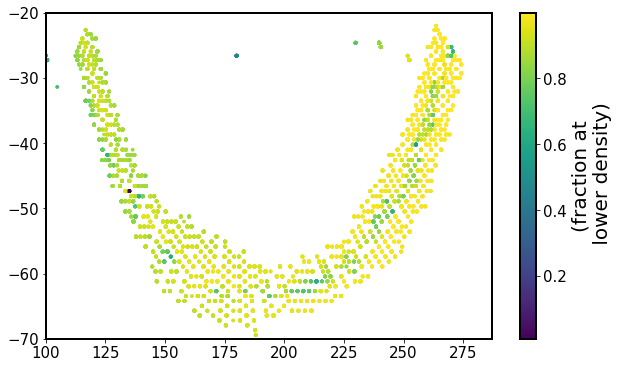

In [11]:
# Plot the DECAPS fields colored by MAF densities 
fig,ax = plt.subplots(1,1,figsize=(10,6))
imge = ax.scatter(np.degrees(decaps_maf['ra_rad']), np.degrees(decaps_maf['dec_rad']),
            c = 1-decaps_maf['frac_greater'],
                  s=8)
plt.colorbar(imge, label='(fraction at\n lower density)')
ax.set_xlim(100,)
ax.set_ylim(-70,-20)

(array([  1.99200000e+03,   1.29600000e+03,   1.19600000e+03,
          8.54000000e+02,   9.85000000e+02,   7.85000000e+02,
          5.83000000e+02,   4.18000000e+02,   4.28000000e+02,
          4.34000000e+02,   1.34000000e+02,   8.00000000e+01,
          9.60000000e+01,   9.20000000e+01,   7.70000000e+01,
          8.20000000e+01,   4.70000000e+01,   1.40000000e+01,
          0.00000000e+00,   2.10000000e+01,   3.80000000e+01,
          1.55000000e+02,   2.30000000e+01,   0.00000000e+00,
          1.00000000e+00,   2.80000000e+01,   1.50000000e+01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([ 0.        ,  0.01666667,  0.03333333,  0.05      ,  0.06666667,
         0.08333333,  0.1       ,  0.11666667,  0.13333333,  0.15      ,
         0.16666667,  0.18333333,  0.2       ,  0.21666667,  0.23333333,
         0.25      ,  0.26666667,  0.28333333,  0.3       ,  0.31666667,
         0.33333333,  0.35      ,  0.36666667,  0.38333333,  0.4       ,
         0.41

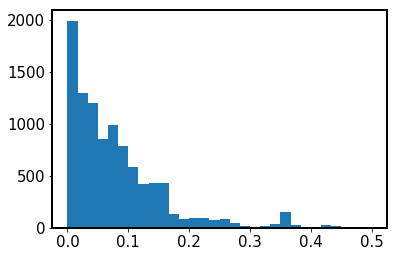

In [117]:
plt.hist(decaps_maf['frac_greater'], range=(0,0.5), bins=30)

Now we make cuts to make the filter and exptime similar to LSST single-visit depth :

In [118]:
np.unique(decaps_maf['filterid'])

Y.0000
g.0000
i.0000
r.0000
z.0000


In [120]:
decaps_maf

visit,prodtype,exptime,mjd_obs,filterid,ra,dec,sb_name,magzero,catfname,dtnsanam,source_density,ra_rad,dec_rad,N_px_greater,frac_greater,d2d_deg
str6,str5,float64,float64,str6,float64,float64,str31,float64,str35,str26,float64,float64,float64,float64,float64,float64
525807,image,5.0,57460.9927059,r.0000,96.1841,-28.77976,c4d_160313_235023_ooi_r_v1.fits,26.832,c4d_160313_235023_ooi_r_v1.cat.fits,c4d_160313_235023_ori.fits,22248.0,1.68124294352,-0.499705040759,16103.0,0.415196988449,0.195167667822
525808,image,96.0,57460.9969294,g.0000,100.0008,-26.92384,c4d_160313_235804_ooi_g_v1.fits,29.646,c4d_160313_235804_ooi_g_v1.cat.fits,c4d_160313_235804_ori.fits,29196.0,1.74260217504,-0.464433821075,13913.0,0.35873040429,0.343651151172
525809,image,96.0,57460.998373,g.0000,99.83377,-27.073,c4d_160314_000006_ooi_g_v1.fits,29.623,c4d_160314_000006_ooi_g_v1.cat.fits,c4d_160314_000006_ori.fits,29196.0,1.74260217504,-0.464433821075,13913.0,0.35873040429,0.46298782973
525810,image,96.0,57460.9998095,g.0000,100.1685,-27.07277,c4d_160314_000215_ooi_g_v1.fits,29.629,c4d_160314_000215_ooi_g_v1.cat.fits,c4d_160314_000215_ori.fits,29232.0,1.75487402134,-0.476119060912,13907.0,0.35857570132,0.395077683453
525811,image,30.0,57461.001244,r.0000,100.0015,-26.9232,c4d_160314_000308_ooi_r_v1.fits,28.844,c4d_160314_000308_ooi_r_v1.cat.fits,c4d_160314_000308_ori.fits,29196.0,1.74260217504,-0.464433821075,13913.0,0.35873040429,0.343323039878
525812,image,30.0,57461.0019313,r.0000,99.83334,-27.07106,c4d_160314_000408_ooi_r_v1.fits,28.832,c4d_160314_000408_ooi_r_v1.cat.fits,c4d_160314_000408_ori.fits,29196.0,1.74260217504,-0.464433821075,13913.0,0.35873040429,0.461055761477
525813,image,30.0,57461.002617,r.0000,100.1688,-27.07151,c4d_160314_000514_ooi_r_v1.fits,28.887,c4d_160314_000514_ooi_r_v1.cat.fits,c4d_160314_000514_ori.fits,29232.0,1.75487402134,-0.476119060912,13907.0,0.35857570132,0.39551344629
525814,image,96.0,57461.0044199,g.0000,126.4261,-43.06979,c4d_160314_000848_ooi_g_v1.fits,29.4545,c4d_160314_000848_ooi_g_v1.cat.fits,c4d_160314_000848_ori.fits,76572.0,2.20659484002,-0.743681425399,7944.0,0.204826732673,0.459986592029
525815,image,30.0,57461.0058628,r.0000,126.426,-43.07055,c4d_160314_000944_ooi_r_v1.fits,28.8275,c4d_160314_000944_ooi_r_v1.cat.fits,c4d_160314_000944_ori.fits,76572.0,2.20659484002,-0.743681425399,7944.0,0.204826732673,0.460746880324


In [12]:
# choose   90 sec < exposure < 125 sec 
# dec < 0  
# filter is  u, g, r,  or VR 
# although it seems that DECAPS has only 
# g,r,i,z,Y ... 

mask_filter = (decaps_maf['filterid'] == 'r.0000') | (decaps_maf['filterid'] == 'g.0000')
print(np.sum(mask_filter))

mask_exp  = (decaps_maf['exptime'].data > 90 ) * (decaps_maf['exptime'] < 125)
print(np.sum(mask_exp))

print(np.sum(mask_exp * mask_filter))

# see what fractions are available...
mask = mask_exp * mask_filter
#np.unique(decaps_maf[mask]['frac_greater'])

# select only those that fulfill both the exposure and filter criteria
selected = decaps_maf[mask]
print(len(selected))
# Just remove from the list the visits that I already processed ...
done_visits  = np.load('processed_visits.npy')
selected = selected[~np.in1d(selected['visit'], done_visits)]
print(len(selected))

4139
2043
2043


In [33]:
selec

In [76]:
# Here we add a column that allows to say that eg. all rows that 
# have density between 13 and 15 are "14" ,  etc.  
densities = [1,3,5,7,10,15,20,25]
# another earlier choice : densitites = [5,10,15,20]

# Initialize with some high number 
selected['density'] = 100

for density in densities : 
    perc = 100*selected['frac_greater'] 
    mask_density = ((density-1) < perc) * (perc < (density+1))
    print(density, np.sum(mask_density))
    selected['density'][mask_density] = density 

1 430
3 278
5 262
7 282
10 189
15 73
20 18
25 23


In [78]:
from astropy.table import vstack

# start from the first density
available = selected[selected['density'] == densities[0]]
selected_visits = Table(np.random.choice(available, size=2))

# add two fields for every density ...
for density in densities[1:]:
    available  = selected[selected['density'] == density]
    add = Table(np.random.choice(available, size=2))
    selected_visits = vstack([selected_visits, add])



In [174]:
selected['sb_name']

c4d_160313_235804_ooi_g_v1.fits
c4d_160314_000006_ooi_g_v1.fits
c4d_160314_000215_ooi_g_v1.fits
c4d_160314_001251_ooi_g_v1.fits
c4d_160314_001457_ooi_g_v1.fits
c4d_160314_001902_ooi_g_v1.fits
c4d_160314_002101_ooi_g_v1.fits
c4d_160314_002508_ooi_g_v1.fits
c4d_160314_002712_ooi_g_v1.fits
c4d_160314_003111_ooi_g_v1.fits
c4d_160314_003316_ooi_g_v1.fits


Plot the distribution on the Sky to show that they are indeed way more random...

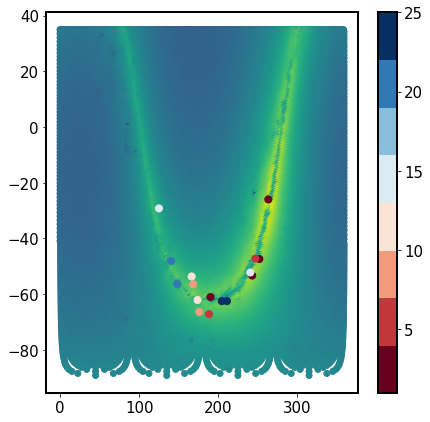

In [80]:
z = np.log10(healpix_table['source_density'].data)
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(healpix_coords.ra.deg, healpix_coords.dec.deg,c=z)
d = len(np.unique(selected_visits['density']))
cmap = plt.get_cmap('RdBu', d) 
image = ax.scatter(selected_visits['ra'], selected_visits['dec'], s=50,
           c=selected_visits['density'],
           cmap=cmap)
plt.colorbar(image)

In [81]:
#In this way I selected 10 visits : two at each density level : 
selected_visits[['frac_greater','density','sb_name','ra','dec', 'exptime', 'visit', 'source_density']]

frac_greater,density,sb_name,ra,dec,exptime,visit,source_density
float64,int64,str31,float64,float64,float64,int64,float64
0.0114222359736,1,c4d_170428_090504_ori.fits,263.4564,-26.02691,96.0,644273,1834416.0
0.01737830033,1,c4d_170428_054642_ori.fits,243.0753,-53.37272,96.0,644144,1292976.0
0.0304764851485,3,c4d_170428_034923_ori.fits,190.3052,-61.0924,96.0,644082,783324.0
0.0338541666667,3,c4d_160826_035203_ooi_g_v1.fits,252.1502,-47.42566,96.0,567795,721728.0
0.0400422854785,5,c4d_160825_020935_ooi_g_v1.fits,247.0427,-47.27046,96.0,567283,612648.0
0.0512324669967,5,c4d_170428_033458_ori.fits,188.4872,-67.27576,96.0,644074,481788.0
0.0669348184818,7,c4d_170421_032337_ori.fits,176.1786,-66.43482,96.0,641548,355896.0
0.0767584570957,7,c4d_160314_055049_ooi_g_v1.fits,168.4693,-56.52539,96.0,526028,305280.0
0.104733910891,10,c4d_170421_015315_ori.fits,166.4679,-53.71243,96.0,641497,205308.0


(array([ 7.,  3.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([   55404. ,   233305.2,   411206.4,   589107.6,   767008.8,
          944910. ,  1122811.2,  1300712.4,  1478613.6,  1656514.8,
         1834416. ]),
 <a list of 10 Patch objects>)

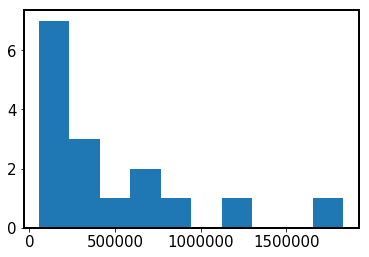

In [82]:
plt.hist(selected_visits['source_density'])

Now I need to obtain the dqmask, wtmap, instcal for these visits to do the LSST processing... I can do that by making an SQL query against the NOAO Public Archive using the fact that the proposal id is characteristic of images obtained ... 

In [83]:
# The propid for the DECAPS is '2016A-0327' and '2016B-0279' : 
np.unique(imdb['propid'])

2016A-0327
2016B-0279


Thus, I would execute a query : 

    SELECT *  FROM voi.siap WHERE ((dtpropid ILIKE '%2016A-0327%') OR (dtpropid ILIKE '%2016B-0279%')) AND (proctype = 'InstCal')) LIMIT 50000

It results in 46890 rows, and I can use these to extract the names of dqmask, wtmap corresponding to my chosen visits. 

I'm having trouble reading the results of this query, so I split it into  two queries : 


    SELECT *  FROM voi.siap WHERE dtpropid ILIKE '%2016A-0327%' AND proctype = 'InstCal' LIMIT 50000

yields 11538 rows  : 

    SELECT *  FROM voi.siap WHERE dtpropid ILIKE '%2016B-0279%' AND proctype = 'InstCal' LIMIT 50000

yields 18524 rows , but there are problems with the result, so I have to limit the output : 

     SELECT reference, release_date, start_date, dtacqnam,filter, exposure, dtnsanam, prodtype, filesize, dtpropid, md5sum  FROM voi.siap WHERE dtpropid ILIKE '%2016B-0279%' AND proctype = 'InstCal' LIMIT 50000

it still yields 18524 rows, but much less cols, and there are no problems with reading. 

In [145]:
#columns  = decaps_rows.colnames
#decaps_rows[:4]
#[x for x in columns if x.startswith('filt')]
#decaps_rows['filter']

In [146]:
# from a file that has imaging, wtmap,  dqmask, select only desired rows ...
 # imaging, dqmask ,wtmap 
import astropy.io.votable as vo

#table = parse_single_table(fname)
#decaps_all = table.to_table()
#vo.is_votable(fname)

# this is the outcome of querying for all from  '%2016A-0327%'
fname1 = 'rows_as_votable_1516932989_6863.vot.xml'  

# these are the results of querying for all from %2016B-0279% , 
# and they can't be read .... 
#fname = 'rows_as_votable_1516932680_713.vot.xml'
#fname = 'rows_as_votable_1517696476_8224.vot.xml'


# this is the outcome of querying for select rows :
# 
#  SELECT reference, release_date, start_date, dtacqnam,filter, 
# exposure, dtnsanam, prodtype, filesize, dtpropid, md5sum  
# FROM voi.siap WHERE dtpropid ILIKE '%2016B-0279%' AND 
# proctype = 'InstCal' LIMIT 50000
#
fname2 = 'rows_as_votable_1517705044_1939.vot.xml'

table1 = vo.parse_single_table(fname1, 
                             invalid='mask') 

decaps_rows1 = table1.to_table()

table2 = vo.parse_single_table(fname2, 
                             invalid='mask') 

decaps_rows2 = table2.to_table()
print(len(decaps_rows1))
print(len(decaps_rows2))

11358
18524


In [152]:
# Stack with hstack : 
cols = decaps_rows2.colnames
decaps_rows = vstack([decaps_rows1[cols], decaps_rows2])



In [154]:
#decaps_rows

In [180]:
# visit comes from dtacqnam 
x1 = len('/data_local/images/DTS/2016A-0327/DECam_00')
x2 = len('.fits.fz')
visit = [line[x1:-x2] for line in decaps_rows['dtacqnam'].data.astype(str)]
decaps_rows['visit'] = visit


In [182]:
m = decaps_rows['visit'] == '644273'
decaps_rows[m]

reference,release_date,start_date,dtacqnam,filter,exposure,dtnsanam,prodtype,filesize,dtpropid,md5sum,visit
object,object,object,object,object,float64,object,object,int32,object,object,str6
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170428_090504_oow_g_v1.fits.fz,2017-04-26,2017-04-27,/data_local/images/DTS/2016B-0279/DECam_00644273.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170428_090504_oow_g_v1.fits.fz,wtmap,321111360,2016B-0279,c0df12f297f2d0624e89312bec34efd1,644273
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170428_090504_ood_g_v1.fits.fz,2017-04-26,2017-04-27,/data_local/images/DTS/2016B-0279/DECam_00644273.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170428_090504_ood_g_v1.fits.fz,dqmask,7476480,2016B-0279,4bbc8961e595cb3ad6f85eebd5637208,644273
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170428_090504_ooi_g_v1.fits.fz,2017-04-26,2017-04-27,/data_local/images/DTS/2016B-0279/DECam_00644273.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170428_090504_ooi_g_v1.fits.fz,image,320912640,2016B-0279,287ee31e298556daa9263ac96158e641,644273


In [156]:
# This quick test ensures that 
# a) each visit number is used only once 
# b) each visit is connected to three rows, 
#    containing image, dqmask, wtmap
counts,values = np.unique(decaps_rows['visit'], return_counts=True)
np.unique(values)

array([3, 4, 5])

We can use visit number to select image, wtmap, dqmask  : 

In [193]:
# Test on one object in 5% region : 
# what are the dqmask, instcal, wtmap ? 
mask_rows = np.in1d(decaps_rows['visit'].data.data.astype(str), 
                    '525904')
decaps_rows[mask_rows]['prodtype', 'exposure', 'dtnsanam', 'filter']

prodtype,exposure,dtnsanam,filter
object,float64,object,object
wtmap,96.0,c4d_160314_023031_ori.fits,g DECam SDSS c0001 4720.0 1520.0
image,96.0,c4d_160314_023031_ori.fits,g DECam SDSS c0001 4720.0 1520.0
dqmask,96.0,c4d_160314_023031_ori.fits,g DECam SDSS c0001 4720.0 1520.0


All we need to do now is to select few visits in each density,  and grab these rows from the votable, and save as votable 

In [219]:
#selected_visits['dtnsanam'].data.astype(str)
N_visits  = len(selected_visits)
print('We selected ', N_visits, ' visits')
selected_visits[['density', 'visit', 'ra','dec', 'catfname', 
                 'source_density', 'frac_greater']]

We selected  16  visits


density,visit,ra,dec,catfname,source_density,frac_greater
int64,int64,float64,float64,str35,float64,float64
1,644273,263.4564,-26.02691,c4d_170428_090504_ooi_g_v1.cat.fits,1834416.0,0.0114222359736
1,644144,243.0753,-53.37272,c4d_170428_054642_ooi_g_v1.cat.fits,1292976.0,0.01737830033
3,644082,190.3052,-61.0924,c4d_170428_034923_ooi_g_v1.cat.fits,783324.0,0.0304764851485
3,567795,252.1502,-47.42566,c4d_160826_035203_ooi_g_v1.cat.fits,721728.0,0.0338541666667
5,567283,247.0427,-47.27046,c4d_160825_020935_ooi_g_v1.cat.fits,612648.0,0.0400422854785
5,644074,188.4872,-67.27576,c4d_170428_033458_ooi_g_v1.cat.fits,481788.0,0.0512324669967
7,641548,176.1786,-66.43482,c4d_170421_032337_ooi_g_v1.cat.fits,355896.0,0.0669348184818
7,526028,168.4693,-56.52539,c4d_160314_055049_ooi_g_v1.cat.fits,305280.0,0.0767584570957
10,641497,166.4679,-53.71243,c4d_170421_015315_ooi_g_v1.cat.fits,205308.0,0.104733910891


In [109]:
#decaps_rows['visit']

In [183]:
#visits  = ['644273', '644144', '644082', '644074', '641548', '641497', '640891',
#          '645251']

In [218]:
#select = np.in1d(decaps_rows['visit'], visits)
select = np.in1d(decaps_rows['visit'], selected_visits['visit'].data.astype(str))

# thus there should be 3*16( dqmask+wtmap+instcal) 
#mask = np.in1d(selected_visits['visit'], decaps_rows[select]['visit'])
#mask = np.in1d(visits, decaps_rows[select]['visit'])
#assert np.sum(select) == 3*len(visits)
assert np.sum(select) == 3*len(selected_visits)

In [191]:
#np.sum(select)

In [199]:
decaps_rows[select]['dtnsanam','prodtype','visit'].sort('visit')

In [209]:
decaps_rows[select]['visit'] = np.array(decaps_rows[select]['visit'].data).astype(int)

In [213]:
decaps_rows[select]['dtnsanam','prodtype','visit'].sort('visit')
m = decaps_rows[select]['visit'] == '644074'
decaps_rows[select]['dtnsanam','prodtype','visit'][m]

dtnsanam,prodtype,visit
object,object,str6
c4d_170428_033458_oow_g_v1.fits.fz,wtmap,644074
c4d_170428_033458_ood_g_v1.fits.fz,dqmask,644074
c4d_170428_033458_ooi_g_v1.fits.fz,image,644074


In [196]:
#selected_visits[['density', 'sb_name', 'exptime', 'filterid', 'visit', 'source_density', 'frac_greater']]

In [197]:
# Display what we have found ... 
#decaps_rows[select]['visit', 'prodtype', 'dtnsanam'][:24]

In [198]:
# save that list of archive filenames 
# as a VOTable to download 
# with secure get 
N = np.sum(select)
fname = 'decaps_NOAO_download_votable_'+str(N)+'.vot.xml'
decaps_rows[select].write(fname,format='votable',
                          overwrite=True)
print('We saved %d names to download as %s'%(N,fname))

We saved 24 names to download as decaps_NOAO_download_votable_24.vot.xml


Now first we need to scp the NCSA the `secure_get.sh`  script:
    
    scp secure_get.sh scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/ 

Now scp to NCSA the VO Table with files to download : 
 
    scp decaps_NOAO_download_votable_48.vot.xml scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/ 

Now ssh to NCSA to download the data from NOAO:
    
    ssh scichris@lsst-dev01.ncsa.illinois.edu
    ./secure_get.sh decaps_NOAO_download_votable_30.vot.xml        
        
Then move the files to correct directories: 
    
    mv c4d*ood*   noao_files/dqmask/
    mv c4d*ooi*   noao_files/instcal/
    mv c4d*oow*   noao_files/wtmap/
    
Then load the LSST Stack tools, and ingest the images to repo : 

    source /ssd/lsstsw/stack/loadLSST.bash
    setup obs_decam
    ingestImagesDecam.py repo/ noao_files/instcal/c4d_160314*.fits.fz
    
Now, ready for processing,  open the detached tmux session and run the processCcd on 5% : 

    tmux 
    processCcd.py repo --rerun proc5perc  --id visit=525904^525920  -C config_processccd.py --clobber-config --clobber-versions  > procmore05.log
    
Detach from tmux session by 

    ctrl+b followed by d 
    
We can check the progress of the processing by either displaying few last lines of the log file, or checking the length of the log file : 

    tail procmore05.log 
    wc -l procmore05.log 
    
Then I run the next density level : 10% : 
    
    tmux 
    processCcd.py repo --rerun proc10perc  --id visit=525846^525879    -C config_processccd.py --clobber-config --clobber-versions  > procmore10.log
    
Thanks to a command that checks which processes are running, I find that the 10% process is no longer running, so I run it again  :procmore10_2.log 

    ps aux | grep scichris
    
Then I run 15% : 

    tmux 
    processCcd.py repo --rerun proc15perc  --id visit=525837^525838    -C config_processccd.py --clobber-config --clobber-versions  > procmore15.log
   
And 20% : 

    tmux 
    processCcd.py repo --rerun proc20perc  --id visit=525814^525900    -C config_processccd.py --clobber-config --clobber-versions  > procmore20.log
    
And 25% : 

    tmux 
    processCcd.py repo --rerun proc25perc  --id visit=525951^525952    -C config_processccd.py --clobber-config --clobber-versions  > procmore25.log

Processing additional visits ( more at each density )  

     tmux 
    processCcd.py repo --rerun proc25perc  --id visit=527096^526152 -C config_processccd.py --clobber-config --clobber-versions  > procadd25.log
    
     tmux 
    processCcd.py repo --rerun proc25perc  --id visit=527096^526152 -C config_processccd.py --clobber-config --clobber-versions  > procadd25.log
    